In [19]:
import torch 
import pandas as pd 
import numpy as np
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader as DataLoader2
from sklearn.metrics import r2_score 
from matplotlib import pyplot as plt 
import pickle as pkl 
import seaborn as sbn 
import pandas as pd 
import pickle as pkl

import sys
sys.path.append('../')
from src.data.PrismDataset import PrismDataset
from src.proc import utils
from src.models.utils import predict_gsnn
from src.models.NN import NN
from src.models.Logistic import Logistic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
data = torch.load('../output/exp1-na/proc/Data.pt')
data

Data(node_names=[5183], edge_index=[2, 16864], input_edge_mask=[16864], output_edge_mask=[16864], input_node_ixs=[3319], output_node_ixs=[452], input_node_mask=[5183], output_node_mask=[5183], cellspace=[78], drugspace=[323])

In [21]:
model = torch.load('../output/exp1-na/GSNN1/93e89891-a363-44fa-9bd9-8ea067b04130/model-45.pt')
#output/exp1-na/GSNN1/93e89891-a363-44fa-9bd9-8ea067b04130

In [22]:
# predict yhat 
prism_train_ids = np.load('../output/exp1-na/proc/prism_train_obs.npy', allow_pickle=True)
prism_test_ids = np.load('../output/exp1-na/proc/prism_test_obs.npy', allow_pickle=True)
prism_val_ids = np.load('../output/exp1-na/proc/prism_val_obs.npy', allow_pickle=True)

# prism datasets 
train_dataset = PrismDataset(root='../output/exp1-na/proc/', data=data, sig_ids=prism_train_ids, target='log_fold_change')
test_dataset = PrismDataset(root='../output/exp1-na/proc/', data=data, sig_ids=prism_test_ids, target='log_fold_change')
val_dataset = PrismDataset(root='../output/exp1-na/proc/', data=data, sig_ids=prism_val_ids, target='log_fold_change')

train_loader = DataLoader(train_dataset, batch_size=500)
test_loader = DataLoader(test_dataset, batch_size=500)
val_loader = DataLoader(val_dataset, batch_size=500)

In [176]:
train_sigids[0]

'MCF7::BRD-A00147595::2.5'

In [23]:
y_train, x_pert_train, train_sigids = predict_gsnn(train_loader, model, data, device='cuda')
x_train = torch.FloatTensor(x_pert_train); y_train = torch.FloatTensor(y_train)
#y_train, x_pert_train, x_unpert_train, train_sigids = predict_gsnn(train_loader, model, data, device='cuda', return_omics=True)
#x_train = torch.FloatTensor(torch.cat((torch.FloatTensor(x_pert_train), torch.FloatTensor(x_unpert_train)), dim=1)); y_train = torch.FloatTensor(y_train)
print()
y_val, x_pert_val, val_sigids = predict_gsnn(val_loader, model, data, device='cuda')
x_val = torch.FloatTensor(x_pert_val); y_val = torch.FloatTensor(y_val)
#y_val, x_pert_val, x_unpert_val, val_sigids = predict_gsnn(val_loader, model, data, device='cuda', return_omics=True)
#x_val = torch.cat((torch.FloatTensor(x_pert_val), torch.FloatTensor(x_unpert_val)), dim=1); y_val = torch.FloatTensor(y_val)
print()
y_test, x_pert_test, test_sigids = predict_gsnn(test_loader, model, data, device='cuda')
x_test = torch.FloatTensor(x_pert_test); y_test = torch.FloatTensor(y_test)
#y_test, x_pert_test, x_unpert_test, test_sigids = predict_gsnn(test_loader, model, data, device='cuda', return_omics=True)
#x_test = torch.FloatTensor(torch.cat((torch.FloatTensor(x_pert_test), torch.FloatTensor(x_unpert_test)), dim=1)); y_test = torch.FloatTensor(y_test)
print()


KeyboardInterrupt: 

In [156]:
# need to identify a subset of "GOOD" drugs, cell lines and predicted genes. Should only predict within these elements. 
# x_train = torch.FloatTensor(x_pert_train); y_train = torch.FloatTensor(y_train)

#r_cell_gene_dict = pkl.load(open('../output/exp1-na/GSNN1/93e89891-a363-44fa-9bd9-8ea067b04130/r_cell_gene_dict.pkl', 'rb'))
#r_cell_gene = pd.DataFrame(r_cell_gene_dict, index=[0]).T.reset_index().rename({'index':'gene', 0:'r_cell'}, axis=1).sort_values('r_cell', ascending=False)

r_gene_dict = pkl.load(open('../output/exp1-na/GSNN1/93e89891-a363-44fa-9bd9-8ea067b04130/r_gene_dict.pkl', 'rb'))
r_gene = pd.DataFrame(r_gene_dict, index=[0]).T.reset_index().rename({'index':'gene', 0:'r'}, axis=1).sort_values('r', ascending=False)

r_drug_dict = pkl.load(open('../output/exp1-na/GSNN1/93e89891-a363-44fa-9bd9-8ea067b04130/r_drug_dict.pkl', 'rb'))
r_drug = pd.DataFrame(r_drug_dict, index=[0]).T.reset_index().rename({'index':'pert_id', 0:'r'}, axis=1).sort_values('r', ascending=False)

best_inferred_genes = r_gene[lambda x: x.r > 0.25].gene.values

best_inferred_drugs = r_drug[lambda x: x.r > 0.25].pert_id.values

print('# best inferred genes:', len(best_inferred_genes))
print('# best inferred drugs:', len(best_inferred_drugs))

# only include predictive genes? or filter to predictive drugs? 

# best inferred genes: 276
# best inferred drugs: 42


In [157]:
# select only the high performing perturbed expression genes 
best_inferred_genes_idx = np.isin(data.node_names[data.output_node_mask], np.array(['LINCS__' + x for x in best_inferred_genes])).nonzero()[0]

x_train2 = x_train[:, best_inferred_genes_idx]
x_test2 = x_test[:, best_inferred_genes_idx]
x_val2 = x_val[:, best_inferred_genes_idx]

# only use obs from drugs that we can predict well. 
#train_drugs = np.array([x.split('::')[1] for x in train_sigids])
#test_drugs = np.array([x.split('::')[1] for x in test_sigids])
#val_drugs = np.array([x.split('::')[1] for x in val_sigids])
#best_inferred_drugs_train_idxs = np.isin(train_drugs, best_inferred_drugs).nonzero()[0]
#best_inferred_drugs_test_idxs = np.isin(test_drugs, best_inferred_drugs).nonzero()[0]
#best_inferred_drugs_val_idxs = np.isin(val_drugs, best_inferred_drugs).nonzero()[0]

#x_train2 = x_train2[best_inferred_drugs_train_idxs]
#x_test2 = x_test2[best_inferred_drugs_test_idxs]
#x_val2 = x_val2[best_inferred_drugs_val_idxs]

#y_train2 = y_train[best_inferred_drugs_train_idxs]
#y_test2 = y_train[best_inferred_drugs_test_idxs]
#y_val2 = y_train[best_inferred_drugs_val_idxs]

mu = x_train2.mean(dim=0).unsqueeze(0)
sigma = x_train2.std(dim=0).unsqueeze(0)

x_train2 = (x_train2 - mu)/(sigma + 1e-12)
x_test2 = (x_test2 - mu)/(sigma + 1e-12)
x_val2 = (x_val2 - mu)/(sigma + 1e-12)

print(x_train2.size())
print(x_test2.size())
print(x_val2.size())

torch.Size([53547, 276])
torch.Size([12164, 276])
torch.Size([9261, 276])


In [171]:
pred = NN(in_channels=x_train2.shape[1], hidden_channels=100, layers=2, out_channels=1, dropout=0.2, nonlin=torch.nn.ELU, out=None, norm=True)
print(pred)
optim = torch.optim.Adam(pred.parameters(), lr=1e-3)#, weight_decay=1e-6) 
crit = torch.nn.MSELoss() 

batch_size = 1024

for epoch in range(1000): 

    for idx in torch.split(torch.arange(x_train2.size(0)), batch_size):
        optim.zero_grad()
        pred.train()
        yhat_train = pred(x_train2[idx]).squeeze()
        loss = crit(yhat_train, y_train[idx] )
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(pred.parameters(), 1, foreach=True)
        optim.step()

    pred.eval() 
    yhat_train = pred(x_train2).squeeze()
    r_train = np.corrcoef(yhat_train.detach().cpu().numpy(), y_train.detach().cpu().numpy())[0,1]
    yhat_val = pred(x_val2).squeeze()
    r2_val = r2_score(y_val.detach().cpu().numpy(), yhat_val.detach().cpu().numpy())

    print(f'epoch: {epoch} | train r: {r_train:.2f} | val r2: {r2_val:.2f}', end='\r')

NN(
  (nn): Sequential(
    (0): Linear(in_features=276, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [172]:
pred.eval()

train_drugs = np.array([x.split('::')[1] for x in np.array(train_sigids)]) #)[best_inferred_drugs_train_idxs]])
test_drugs = np.array([x.split('::')[1] for x in np.array(test_sigids)]) #)[best_inferred_drugs_test_idxs]])
val_drugs = np.array([x.split('::')[1] for x in np.array(val_sigids)]) #)[best_inferred_drugs_val_idxs]])

drug_perf = {}
for drug in np.unique(train_drugs): 
    drug_idxs = (train_drugs == drug).nonzero()[0]
    _yhat = pred(x_train2[drug_idxs]).squeeze()
    _y = y_train[drug_idxs]
    drug_perf[drug] = r2_score(_y.detach().cpu().numpy(), _yhat.detach().cpu().numpy())

drug_perf = pd.DataFrame(drug_perf, index=[0]).T.reset_index().rename({'index': 'pert_id', 0:'r2_train'}, axis=1)

drug_perf2 = {}
for drug in np.unique(test_drugs): 
    drug_idxs = (test_drugs == drug).nonzero()[0]
    _yhat = pred(x_test2[drug_idxs]).squeeze()
    _y = y_test[drug_idxs]
    drug_perf2[drug] = r2_score(_y.detach().cpu().numpy(), _yhat.detach().cpu().numpy())

drug_perf2 = pd.DataFrame(drug_perf2, index=[0]).T.reset_index().rename({'index': 'pert_id', 0:'r2_test'}, axis=1)

drug_perf3 = {}
for drug in np.unique(val_drugs): 
    drug_idxs = (val_drugs == drug).nonzero()[0]
    _yhat = pred(x_val2[drug_idxs]).squeeze()
    _y = y_val[drug_idxs]
    drug_perf3[drug] = r2_score(_y.detach().cpu().numpy(), _yhat.detach().cpu().numpy())

drug_perf3 = pd.DataFrame(drug_perf3, index=[0]).T.reset_index().rename({'index': 'pert_id', 0:'r2_val'}, axis=1)

drug_perf = drug_perf.merge(drug_perf2, on='pert_id', how='left').merge(drug_perf3, on='pert_id', how='left').sort_values(by='r2_test', ascending=False)
drug_perf.head(10)

,pert_id,r2_train,r2_test,r2_val
208,BRD-K99545815,0.819552,0.663323,-0.959692
40,BRD-K11636097,0.726780,0.661525,0.483036
47,BRD-K13390322,0.648040,0.601067,0.275154
49,BRD-K13662825,0.714756,0.600811,0.306043
104,BRD-K44227013,0.713601,0.598081,0.031936
80,BRD-K28360340,0.841908,0.573355,0.215453
102,BRD-K43578482,0.746162,0.554475,-4.975723
61,BRD-K17743125,0.653440,0.544809,-0.858118
189,BRD-K88510285,0.756748,0.529985,0.415759
45,BRD-K12867552,0.900261,0.510256,0.272955


In [173]:
drug_perf.corr()

/tmp/ipykernel_25269/197720671.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  drug_perf.corr()


,r2_train,r2_test,r2_val
r2_train,1.000000,0.667471,0.191716
r2_test,0.667471,1.000000,0.381529
r2_val,0.191716,0.381529,1.000000


0.3512931120688765


/tmp/ipykernel_25269/1924002334.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr().values[0,1])


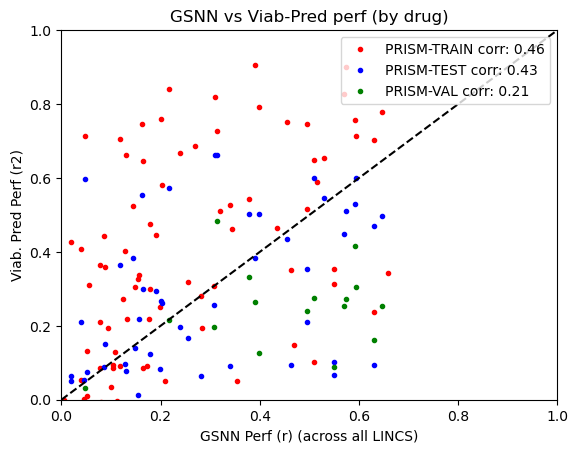

In [174]:
df = r_drug.merge(drug_perf, on='pert_id', how='left')
print(df.corr().values[0,1])
plt.figure()
plt.plot(df.r, df.r2_train, 'r.', label=f'PRISM-TRAIN corr: {df[lambda x: (x.r > 0) & (x.r2_train > 0)][["r", "r2_train"]].corr(method="spearman").values[0,1]:.2f}')
plt.plot(df.r, df.r2_test, 'b.', label=f'PRISM-TEST corr: {df[lambda x: (x.r > 0) & (x.r2_test > 0)][["r", "r2_test"]].corr(method="spearman").values[0,1]:.2f}')
plt.plot(df.r, df.r2_val, 'g.', label=f'PRISM-VAL corr: {df[lambda x: (x.r > 0) & (x.r2_val > 0)][["r", "r2_val"]].corr(method="spearman").values[0,1]:.2f}')

plt.xlim(0,1)
plt.ylim(0,1)
plt.plot((0,1), (0,1), 'k--')
plt.xlabel('GSNN Perf (r) (across all LINCS)')
plt.ylabel('Viab. Pred Perf (r2)')
plt.title('GSNN vs Viab-Pred perf (by drug)')
plt.legend()
plt.show()

r test 0.5306675164596687
r2 0.26490227922761456


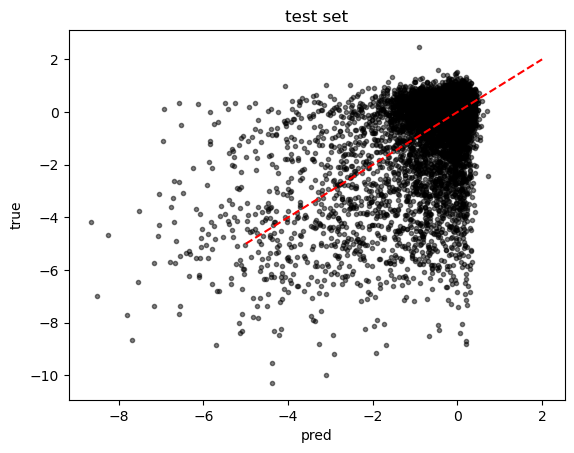

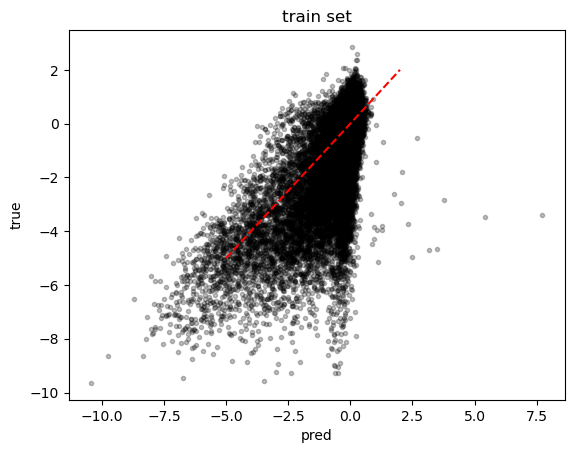

In [166]:
pred.eval()
yhat_test = pred(x_test2).squeeze()
yhat_train = pred(x_train2).squeeze()
r_test = np.corrcoef(yhat_test.detach().cpu().numpy(), y_test.detach().cpu().numpy())[0,1]
print('r test', r_test)
print('r2', r2_score(y_test.detach().cpu().numpy().ravel(), yhat_test.detach().cpu().numpy().ravel()))

plt.figure()
plt.xlabel('pred'); plt.ylabel('true')
plt.title('test set')
plt.plot(yhat_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), 'k.', alpha=0.5)
plt.plot((-5,2), (-5,2), 'r--')
plt.show()

plt.figure()
plt.title('train set')
plt.xlabel('pred'); plt.ylabel('true')
plt.plot(yhat_train.detach().cpu().numpy(), y_train.detach().cpu().numpy(), 'k.', alpha=0.25)
plt.plot((-5,2), (-5,2), 'r--')
plt.show()

In [ ]:
t = -2 

y_train2 = (y_train < t)*1.
y_test2 = (y_test < t)*1.
y_val2 = (y_val < t)*1.

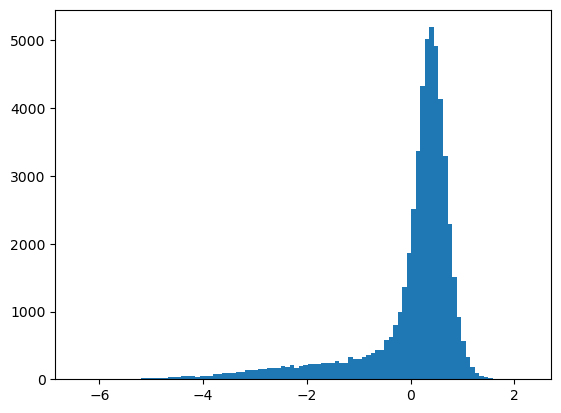

In [ ]:
plt.figure()
plt.hist(y_train, bins=100)
plt.show()

In [ ]:
train_sigids[0]

'MCF7::BRD-A00147595::2.5'

In [ ]:
# should add a step here to select output genes that are well predicted - particularly for explaining cell-cell variance. 
# e.g., best_inferred = A,B,C 
#       x_best_inferred = x[:, best_inferred]
# 

In [ ]:
def train_pred(y_train, y_val, y_test, p=0.5): 

    pred = NN(in_channels=x_train.shape[1], hidden_channels=10, layers=2, out_channels=1, dropout=0.2, nonlin=torch.nn.ELU, out=torch.nn.Sigmoid)
    optim = torch.optim.Adam(pred.parameters(), lr=1e-4) 
    #crit = torch.nn.MSELoss() 
    crit = torch.nn.BCELoss() 

    idx = torch.randperm(y_train.size(0))[:int(y_train.size(0)*p)]

    for epoch in range(100): 

        optim.zero_grad()
        pred.train()
        yhat_train = pred(x_train[idx, :]).squeeze()
        loss = crit(yhat_train, y_train[idx] )
        loss.backward()
        optim.step()

        pred.eval() 
        yhat_train = pred(x_train).squeeze()
        r_train = np.corrcoef(yhat_train.detach().cpu().numpy(), y_train.detach().cpu().numpy())[0,1]
        yhat_val = pred(x_val).squeeze()
        r_val = np.corrcoef(yhat_val.detach().cpu().numpy(), y_val.detach().cpu().numpy())[0,1]

        print(f'epoch: {epoch} | train r: {r_train:.2f} | val r: {r_val:.2f}', end='\r')

    yhat_test = pred(x_test).squeeze()
    r_test = np.corrcoef(yhat_test.detach().cpu().numpy(), y_test.detach().cpu().numpy())[0,1]
    print('r test', r_test)

    return pred 

In [ ]:
ensemble = [] 
for i in range(10): 
    ensemble.append(train_pred(y_train, y_val, y_test)) 

r test 0.4996468302658726 | val r: 0.351
r test 0.5205260216556973 | val r: 0.34
r test 0.4866140985365912 | val r: 0.34
r test 0.49584426865559184| val r: 0.33
r test 0.4779650669494907 | val r: 0.33
r test 0.4544695056914315 | val r: 0.33
r test 0.5290372548375083 | val r: 0.34
r test 0.4878345394897076 | val r: 0.34
r test 0.5077854188834091 | val r: 0.39
r test 0.5369227425353195 | val r: 0.35


In [ ]:
yhat_test = [] 
for m in ensemble: 
    yhat_test.append(m(x_test).squeeze())

yhat_test = torch.stack(yhat_test, dim=1)
yhat_test.size()

torch.Size([12164, 10])

In [ ]:
np.corrcoef(y_test.detach().cpu().numpy(), yhat_test.mean(dim=1).detach().cpu().numpy())[0,1]

0.5064075565745948

In [ ]:
for epoch in range(1000): 

    optim.zero_grad()
    pred.train()
    yhat_train = pred(x_train).squeeze()
    loss = crit(yhat_train, y_train )
    loss.backward()
    optim.step()

    pred.eval() 
    yhat_train = pred(x_train).squeeze()
    r_train = np.corrcoef(yhat_train.detach().cpu().numpy(), y_train.detach().cpu().numpy())[0,1]
    yhat_val = pred(x_val).squeeze()
    r_val = np.corrcoef(yhat_val.detach().cpu().numpy(), y_val.detach().cpu().numpy())[0,1]

    print(f'epoch: {epoch} | train r: {r_train:.2f} | val r: {r_val:.2f}', end='\r')



In [ ]:
yhat_test = pred(x_test).squeeze()
r_test = np.corrcoef(yhat_test.detach().cpu().numpy(), y_test.detach().cpu().numpy())[0,1]
r_test

-0.48673186988203615

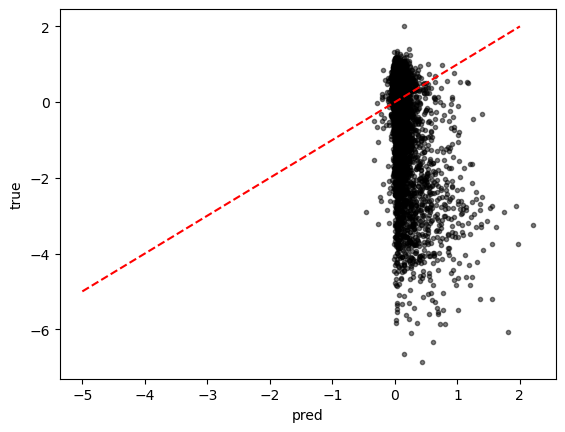

In [ ]:
plt.figure()
plt.xlabel('pred'); plt.ylabel('true')
plt.plot(yhat_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), 'k.', alpha=0.5)
plt.plot((-5,2), (-5,2), 'r--')
plt.show()

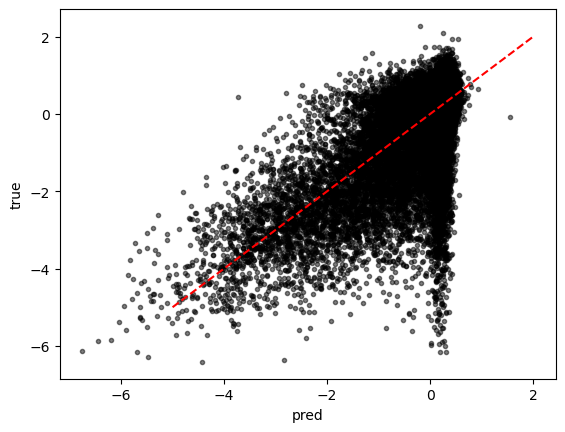

In [ ]:
plt.figure()
plt.xlabel('pred'); plt.ylabel('true')
plt.plot(yhat_train.detach().cpu().numpy(), y_train.detach().cpu().numpy(), 'k.', alpha=0.5)
plt.plot((-5,2), (-5,2), 'r--')
plt.show()

In [ ]:
class GSNN2VIAB(torch.nn.Module): 
    '''
    frozen GSNN -> viab model 

    out = f_viab(f_gsnn(x))
    ''' 
    
    def __init__(self, model, pred, out_mask=None): 
        '''

        Args: 
            model       torch.Module            trained GSNN model 
            pred        torch.Module            trained cell viab model 
            out_mask    torch.tensor            boolean tensor specifying which outputs are used as input to cell viab model 
        '''
        super().__init__()

        self.model = model
        self.model.training = False 
        for p in self.model.parameters(): p.requires_grad = False

        self.pred = pred 
        self.pred.training = False 
        for p in self.pred.parameters(): p.requires_grad = False

        self.out_mask = out_mask 

    def forward(self, x): 

        out = self.model(x)
        if self.out_mask is not None: out = out[self.out_mask]

        out = self.pred(out) 

        return out 
    

    




In [ ]:
class DrugPrioritization(torch.nn.Module): 
    '''
    Module for drug priortization. 

    Intended to be used in tandem with a target response dataset (x), e.g., a user-defined set of (cell lines, response) pairs that display a desired therapeutic behavior. 

    To induce sparsity in drug priortiziation, we allow the user to specify the order of drug combinations (1 indicates single agent prioritization), and we use the gumbel-softmax 
    function to ensure the constraint. 

    In 1d, this can be thought of as a categorical sampling operation over all drugs. 

    theta = [d1, d2, ..., dn] 
    samp  = [0,  1 , ..., 0 ]

    In 2d, this is again viewed as categorical sampling; however we perform this on a grid representing drug1 (rows) and drug2 (cols). 
    NOTE: we assume drug1,drug2 = drug2,drug1 and that drug1=/=drug2, therefore we only need to include the upper triangle during sampling (diagonal +1). 

    theta = 
        d1,  d2, ...,  dn
    d1  na  d1d2 ...  d1dn
    d2  na  na   ...  d2dn
    ... ... ...  ...  ...
    dn  na  na   ...   na

    drug1 ~ sum(theta, axis=0)
    drug2 ~ sum(theta, axis=1)

    This could be expanded to higher order combinations, but for now we will focus on only 1 (no comb) or 2 drugs combinations. 
        for 3-drug combinations or higher, this becomes less intuitive; however, the equivalent behavior can be achieved by summing over multiple dimensions. Assuming theta is a cube or hyper-cube, then:
        3-drug: drug1 = sum(theta, axis=[0,1]),   drug2 = sum(theta, axis=[1,2],    drug3 = sum(theta, axis[0,2]))
        4-drug: drug1 = sum(theta, axis=[0,1,2]), drug2 = sum(theta, axis=[0,1,3]), drug3 = sum(theta, axis=[0,2,3]), drug4 = sum(theta, axis=[1,2,3])
        etc... 


    To learn optimal drug concentrations, we also use a trainable scale parameter of the same shape as theta, such that drug_conc = gumbel_softmax(theta)*scale

    '''

    def __init__(self, model, drug_mask, comb=False): 
        ''' 

        Args: 
            pred                cell viab model 
            drug_mask           tensor              boolean mask for which drugs should be included in the priortiziation search; drugs with a false label will be assigned a value of zero for the search.  
            comb                bool                whether to search over all 2-drug combinations or single agents. 
        '''
        super().__init__()

        self.model = model

        self.comb= comb
        self.drug_mask = drug_mask
        self.N = int(drug_mask.sum())

        if self.comb: 
            nparams = int((self.N**2 - self.N)/2)
            self.theta = torch.nn.Parameter(torch.zeros(nparams))
            self.scale = torch.nn.Parameter(torch.ones(nparams))
            self.dim = (self.N, self.N)
        else: 
            nparams = self.N
            self.theta = torch.nn.Parameter(torch.zeros(nparams))
            self.scale = torch.nn.Parameter(torch.ones(nparams))
            self.dim = (self.N)


    def forward(self, x, tau=1.): 
        ''' 
        x is assumed to have zero drug perturbations; e.g., all drug nodes are equal to zero
        '''
        # sample drug combination 
        s = torch.nn.functional.gumbel_softmax(self.theta.view(-1,1), tau=tau, hard=False)*self.scale.view(-1,1) 
        d = torch.zeros(self.dim, device=x.device)
        if self.comb: 
            d[torch.triu_indices(self.N, self.N, offset=1)] += s
        else: 
            d += s

        xc = torch.zeros_like(x)
        for i in range(len(d.size())): xc[self.drug_mask] += d.sum(dim=i) 

        # add the sampled drug perturbation
        x += xc

        # predict response 
        return self.model(x)

In [ ]:
prism = utils.load_prism('../../data/', cellspace=data.cellspace, drugspace=data.drugspace)

In [ ]:
prism.head()

,pert_id,depmap_id,cell_iname,pert_dose,log_fold_change,screen_id,num_repl,sig_id,cell_viab
0,BRD-K07106112,ACH-000019,MCF7,0.000610,0.292371,[secondary],1,MCF7::BRD-K07106112::0.00061034,1.224651
1,BRD-K07106112,ACH-000019,MCF7,0.002441,0.420013,[secondary],1,MCF7::BRD-K07106112::0.0024414,1.337940
2,BRD-K07106112,ACH-000019,MCF7,0.009766,-0.038470,[secondary],1,MCF7::BRD-K07106112::0.00976562,0.973687
3,BRD-K07106112,ACH-000019,MCF7,0.039062,0.678407,[secondary],1,MCF7::BRD-K07106112::0.0390625,1.600372
4,BRD-K07106112,ACH-000019,MCF7,0.156250,0.021690,[secondary],1,MCF7::BRD-K07106112::0.15625,1.015148


In [ ]:
data

Data(node_names=[814], edge_index=[2, 1222], input_edge_mask=[1222], output_edge_mask=[1222], input_node_ixs=[560], output_node_ixs=[100], input_node_mask=[814], output_node_mask=[814], cellspace=[75], drugspace=[74])

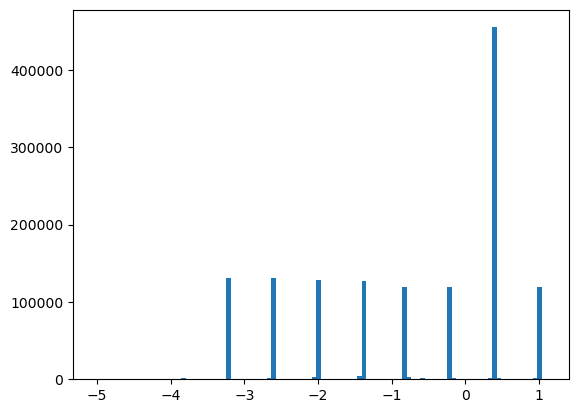

In [ ]:
plt.figure()
plt.hist(np.log10(prism.pert_dose.values), bins=100)
plt.show()

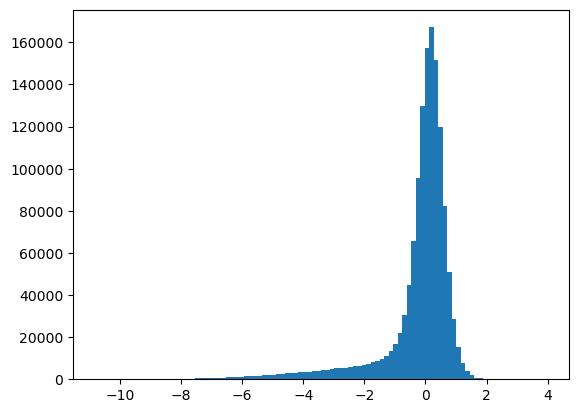

In [ ]:
plt.figure()
plt.hist(prism.log_fold_change, bins=100)
plt.show()